> NBD models with spikes

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import os
from IPython.display import display, Image
import plotly.graph_objs as go

# Function

In [239]:
def compute_probabilities(alpha, r, t, num_bins, spike = None, val = 0, truncated = 0):
    '''Compute the probability of a person landing in one of the discrete buckets'''
    if spike is None:
        p = [(alpha / (alpha + t))**r]
        for x in range(1, num_bins-1):
            p.append(t * (r + x - 1) / x / (alpha + t) * p[x-1])

        # add remaining probability to right censored cell
        p.append(1 - np.sum(p))

        return p[truncated:]
    else:
        p = [(alpha / (alpha + t))**r]
        for x in range(1, num_bins-1):
            p.append(t * (r + x - 1) / x / (alpha + t) * p[x-1])

        # add remaining probability to right censored cell
        p.append(1 - np.sum(p))
        supp = [1-val] * len(p)
        rp = np.array(supp)*p
        rp[spike] = rp[spike] + val
        
        return(list(rp))

def log_likelihood(alpha, r, t, values, counts, spike = None, val = 0, truncated = 0):
    '''Objective function that we need to maximize to get best alpha and r params'''
    if spike is None:
        if alpha <= 0 or r <= 0:
            return -99999
        probabilities = np.array(compute_probabilities(alpha, r, t, len(values), truncated = truncated))
        probabilities = probabilities/np.sum(probabilities)
        
        return np.sum(np.log(probabilities) * np.array(counts)[truncated:])
    else:
        if alpha <= 0 or r <= 0:
            return -99999
        probabilities = np.array(compute_probabilities(alpha, r, t, len(values),spike,val))

        return np.sum(np.log(probabilities) * np.array(counts))
        
def maximize(values, counts, spike = None, truncated = 0):
    '''Maximize log-likelihood by searching for best (alpha, r) combination'''
    if spike is None:
        func = lambda x: -log_likelihood(x[0], x[1], 1, values, counts, truncated = truncated)
        x0 = np.array([100., 100.])
        res = minimize(func, x0, method='Nelder-Mead', options={'xtol': 1e-8, 'disp': False})

        return res.x
    else:
        func = lambda x: -log_likelihood(x[0], x[1], 1, values, counts, spike = spike, val = x[2])
        x0 = np.array([1., 1., 0.2])
        bnds = ((0.00001, None), (0.00001, None), (0.00001,0.99999))
        res = minimize(func, x0, bounds=bnds)

        return res.x

def forecast(values, counts, t, spike = None, truncated = 0):
    '''Fits the nBD model to the data'''
    if spike is None:
        # Generate best alpha, r
        alpha, r = maximize(values, counts, truncated = truncated)

        # Calculate probabilities
        probabilities = compute_probabilities(alpha, r, t, len(values))

        # Scale expectations to population
        if truncated == 0:
            return probabilities * np.array([np.sum(counts)] * len(probabilities))
        else:
            p1 = list(probabilities[1:]/np.sum(probabilities[1:]))
            c1 = np.array([np.sum(counts[1:])] * len(probabilities[1:]))
            observed = p1 * c1
            unobserved = [np.sum(counts[1:])]/np.sum(probabilities[1:]) - [np.sum(counts[1:])]
            return list(unobserved) + list(observed)
    else:
        # Generate best alpha, r
        alpha, r, pi = maximize(values, counts, spike)

        # Calculate probabilities
        probabilities = compute_probabilities(alpha, r, t, len(values), spike,pi)

        # Scale expectations to population
        return probabilities * np.array([np.sum(counts)] * len(probabilities))


def fixed_forecast(values, counts, alpha, r, t):
    '''Forecasts with fixed alpha and r obtained from initial fit'''
    # Calculate probabilities
    probabilities = compute_probabilities(alpha, r, t, len(values))
    
    # Scale expectations to population
    return probabilities * np.array([np.sum(counts)] * len(probabilities))

# Example

In [240]:
df = pd.read_csv("data/Coffee creamer NBD.csv")

In [241]:
maximize(df.X,df.N_x)

array([0.05907792, 0.18095184])

In [242]:
maximize(df.X,df.N_x,truncated=1)

array([0.21515571, 1.22648101])

In [243]:
maximize(df.X,df.N_x, 0)

array([0.21515463, 1.22647475, 0.55064383])

In [244]:
#Rejecting Spike
maximize(df.X,df.N_x, 1)

array([5.90760943e-02, 1.80948296e-01, 1.00000000e-05])

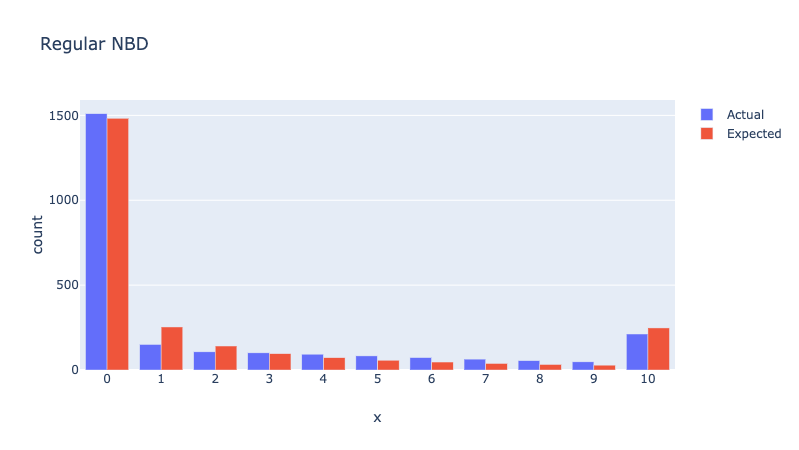

In [249]:
fig = go.Figure(data=[
    go.Bar(name='Actual', x=df.X, y=df.N_x),
    go.Bar(name='Expected', x=df.X, y=forecast(df.X,df.N_x,1))
])

fig.update_layout(title='Regular NBD',
                  xaxis_title='x',
                  yaxis_title='count',
                 annotations=[
                    
                      ],
                  xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 1
                        )
                 )

# Change the bar mode
fig.update_layout(barmode='group')

fig.show()

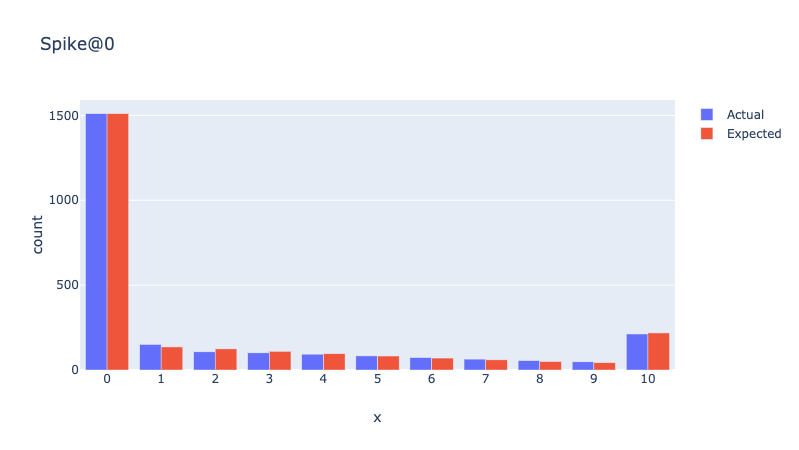

In [250]:
fig = go.Figure(data=[
    go.Bar(name='Actual', x=df.X, y=df.N_x),
    go.Bar(name='Expected', x=df.X, y=forecast(df.X,df.N_x,1, 0))
])

fig.update_layout(title='Spike@0',
                  xaxis_title='x',
                  yaxis_title='count',
                 annotations=[
                    
                      ],
                  xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 1
                        )
                 )

# Change the bar mode
fig.update_layout(barmode='group')

fig.show()

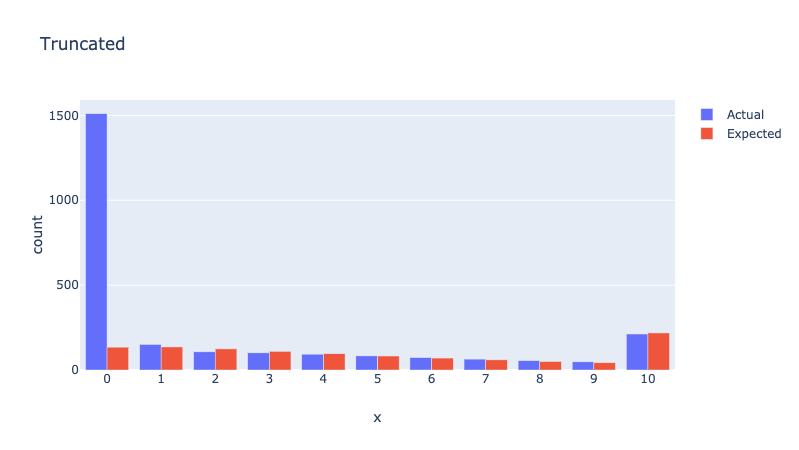

In [251]:
fig = go.Figure(data=[
    go.Bar(name='Actual', x=df.X, y=df.N_x),
    go.Bar(name='Expected', x=df.X, y=forecast(df.X,df.N_x,1,truncated=1))
])

fig.update_layout(title='Truncated',
                  xaxis_title='x',
                  yaxis_title='count',
                 annotations=[
                    
                      ],
                  xaxis = dict(
                        tickmode = 'linear',
                        tick0 = 0,
                        dtick = 1
                        )
                 )

# Change the bar mode
fig.update_layout(barmode='group')

fig.show()